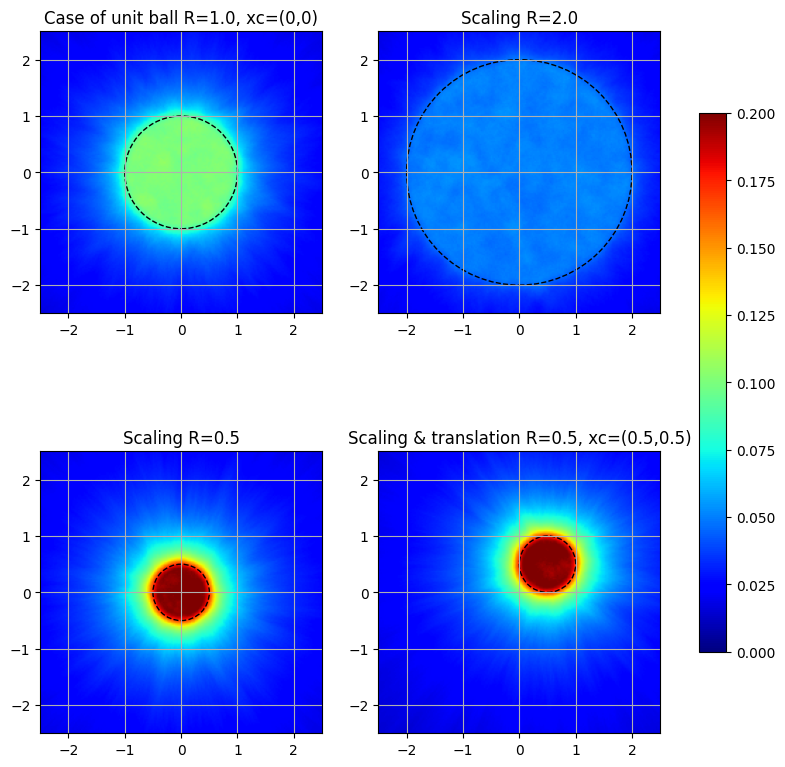

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_planes(M, d=2):
    # 随机生成法向量 a_m
    a = np.random.randn(M, d)
    a = a / np.linalg.norm(a, axis=1, keepdims=True)  # normalize
    return a

def density_field(M=30000, tau=0.1, R=1.0, xc=(0.0,0.0), grid_size=200):
    a = generate_planes(M)
    r = np.random.uniform(0, R, M)  # 偏移量
    xc = np.array(xc)

    # 网格
    x = np.linspace(-2.5, 2.5, grid_size)
    y = np.linspace(-2.5, 2.5, grid_size)
    X, Y = np.meshgrid(x, y)
    pts = np.stack([X, Y], axis=-1).reshape(-1, 2) # store all the coordinates

    # 计算所有 d_m(x)
    vals = np.zeros(len(pts))
    for m in range(M):
        dists = np.abs(pts @ a[m] + r[m] - a[m] @ xc)
        vals += (dists < tau).astype(float)
    vals /= M

    return X, Y, vals.reshape(grid_size, grid_size)

# 绘制四个子图
cases = [
    (1.0, (0,0), "Case of unit ball R=1.0, xc=(0,0)"),
    (2.0, (0,0), "Scaling R=2.0"),
    (0.5, (0,0), "Scaling R=0.5"),
    (0.5, (0.5,0.5), "Scaling & translation R=0.5, xc=(0.5,0.5)")
]

fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i,(R,xc,title) in enumerate(cases):
    X, Y, Z = density_field(M=30000, tau=0.1, R=R, xc=xc, grid_size=200)
    ax = axs[i//2, i%2]
    im = ax.imshow(Z, extent=[-2.5,2.5,-2.5,2.5], origin='lower',
                   cmap='jet', vmin=0, vmax=0.2)
    # 边界圆
    circle = plt.Circle(xc, R, color='k', fill=False, linestyle='--')
    ax.add_patch(circle)
    ax.set_title(title)
    ax.set_xlim(-2.5,2.5)
    ax.set_ylim(-2.5,2.5)
    ax.set_aspect('equal')
    ax.grid(True)

fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.7)
plt.show()


Using gamma = 13.333333333333334
LS solved. residuals sum = [] rank=63


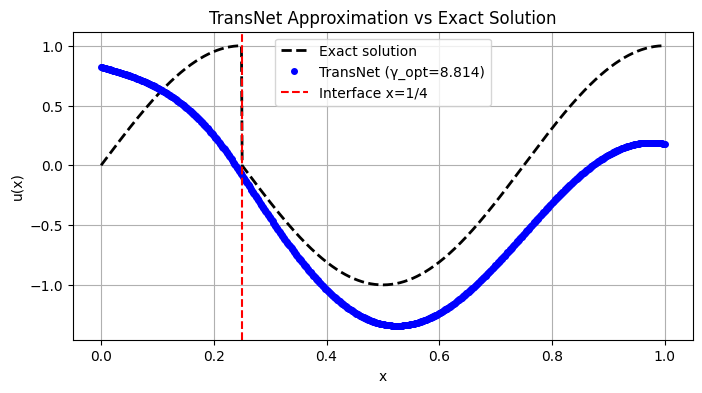

In [69]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Problem / exact solution
# -------------------------
def u_exact(x):
    """Exact solution u(x) as in paper: sin(2πx) for x<=1/4, cos(2πx) for x>1/4"""
    x = np.array(x)
    return np.where(x <= 0.25, np.sin(2*np.pi*x), np.cos(2*np.pi*x))

def u_exact_prime(x):
    """First derivative of exact solution (piecewise)"""
    x = np.array(x)
    return np.where(x <= 0.25, 2*np.pi*np.cos(2*np.pi*x), -2*np.pi*np.sin(2*np.pi*x))

def u_exact_second(x):
    """Second derivative of exact solution (piecewise)"""
    x = np.array(x)
    return np.where(x <= 0.25, - (2*np.pi)**2 * np.sin(2*np.pi*x),
                               - (2*np.pi)**2 * np.cos(2*np.pi*x))

# diffusion coefficient beta(x)
def beta(x):
    x = np.array(x)
    return np.where(x <= 0.25, 1.0, 10.0)

# For collocation points away from interface we can compute f(x) = - (beta u')'
# since beta piecewise constant, away from interface (no delta) f = - beta * u_exact_second
def f_rhs(x):
    return - beta(x) * u_exact_second(x)

# -------------------------
# TransNet setup
# -------------------------
M = 100                 # number of hidden neurons
x_c = 0.5               # center of covering ball
R = 0.6                 # radius to slightly cover [0,1]

# Sample a_m: in d=1, we sample standard normal and normalize -> sign => ±1
np.random.seed(0)
a_raw = np.random.normal(size=M)
a_m = np.sign(a_raw)    # +1 or -1
a_m[a_m == 0] = 1.0     # just in case

# Sample r_m uniformly in [0,1] (per your instruction)
r_m = np.random.uniform(0.0, 1.0, size=M)

# empirical gamma: use gamma = C * M^{1/d} / R with a small C (default)
# paper mentions such relation; we pick a reasonable C ~ 0.08 (can be tuned)
C = 0.08
d = 1
gamma = C * (M**(1.0/d)) / R
print("Using gamma =", gamma)

# activation and derivatives for tanh
def sigma(z):
    return np.tanh(z)

def sigma_prime(z):
    t = np.tanh(z)
    return 1.0 - t*t        # sech^2

def sigma_second(z):
    t = np.tanh(z)
    # derivative of (1 - t^2) = -2 t (1 - t^2)
    return -2.0 * t * (1.0 - t*t)

# basis functions phi_m(x) and their derivatives
def z_vals(x):
    # returns shape (len(x), M) array of z_{m}(x) = gamma*(a_m*(x-x_c)+r_m)
    x = np.atleast_1d(x)[:, None]            # shape (N,1)
    am = a_m[None, :]                        # shape (1,M)
    rm = r_m[None, :]                        # shape (1,M)
    return gamma * (am * (x - x_c) + rm)     # (N,M)

# -------------------------
# Collocation and assembly
# -------------------------
# choose collocation points in (0,1) excluding the interface exact point 0.25
N_coll = 300
x_col = np.linspace(0.0, 1.0, N_coll)
# avoid sampling exactly at interface to avoid delta issues
x_col = x_col[np.abs(x_col - 0.25) > 1e-8]

# Evaluate z, activation and derivatives on collocation
Z = z_vals(x_col)                    # (Nc, M)
Phi = np.tanh(Z)                     # (Nc, M)
Phi_p = sigma_prime(Z) * (gamma * a_m[None, :])     # ∂/∂x phi_m = sigma'(z) * gamma * a_m
Phi_pp = sigma_second(Z) * (gamma**2 * (a_m[None,:]**2))  # ∂^2/∂x^2 phi_m = sigma''(z) * gamma^2 * a_m^2
# Note: a_m^2 = 1 in 1D, but keep general form

# Build least-squares system A alpha = b
# For collocation residual: - (beta * u')' = f  => use - beta * u''  (beta' = 0 away from interface)
Nc = len(x_col)
A_coll = np.zeros((Nc, M+1))   # +1 for alpha_0 (constant)
b_coll = np.zeros(Nc)

b_coll[:] = f_rhs(x_col)       # right-hand side f evaluated at collocation points

beta_col = beta(x_col)
# Each column m: contribution of basis m to operator L applied => - beta * phi_pp
A_coll[:, :M] = - (beta_col[:, None]) * Phi_pp
# constant term alpha_0 contributes zero to second derivative -> its column remains zeros

# Boundary conditions u(0)=u_exact(0), u(1)=u_exact(1)
# as two rows in the LS system
A_b = np.zeros((2, M+1))
b_b = np.zeros(2)
x_b = np.array([0.0, 1.0])
b_b[:] = u_exact(x_b)

Zb = z_vals(x_b)            # (2, M)
Phib = np.tanh(Zb)          # (2, M)
A_b[:, :M] = Phib
A_b[:, M] = 1.0             # alpha_0 column

# Combine
A = np.vstack([A_coll, A_b])
b = np.concatenate([b_coll, b_b])

# Solve least squares for alpha (alpha_1..alpha_M and alpha_0)
# Use numpy lstsq
alpha, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
alpha_m = alpha[:M]
alpha_0 = alpha[M]
print(f"LS solved. residuals sum = {residuals} rank={rank}")

# -------------------------
# Build u_NN on a fine grid and compare with exact
# -------------------------
x_test = np.linspace(0.0, 1.0, 800)
Z_test = z_vals(x_test)
Phi_test = np.tanh(Z_test)           # (Nt, M)
u_nn_vals = Phi_test.dot(alpha_m) + alpha_0
u_exact_vals = u_exact(x_test)

# =========================
# 绘制圈点风格图像
# =========================
plt.figure(figsize=(8,4))

# 精确解：黑色虚线
plt.plot(x_test, u_exact_vals, 'k--', lw=2, label='Exact solution')

# TransNet 解：蓝色圆圈
plt.plot(x_test, u_nn_vals, 'bo', markersize=4, label=f'TransNet (γ_opt={gamma_opt:.3f})')

# 界面位置
plt.axvline(0.25, color='r', linestyle='--', label='Interface x=1/4')

plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('TransNet Approximation vs Exact Solution')
plt.legend(); plt.grid(True)
plt.show()


Starting golden-section search for gamma1 (this may take some time)...
Found gamma1_opt = 2.536568e+00, gamma2_opt = 8.894459e-01
Final LS residual (sum squares): [633943.7256721]


/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_74310/1471977600.py:309: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_pred[i] = B.dot(alpha1)
/var/folders/42/tjxv8ldx65x5b07fdgrxyw5w0000gn/T/ipykernel_74310/1471977600.py:312: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u_pred[i] = B.dot(alpha2)


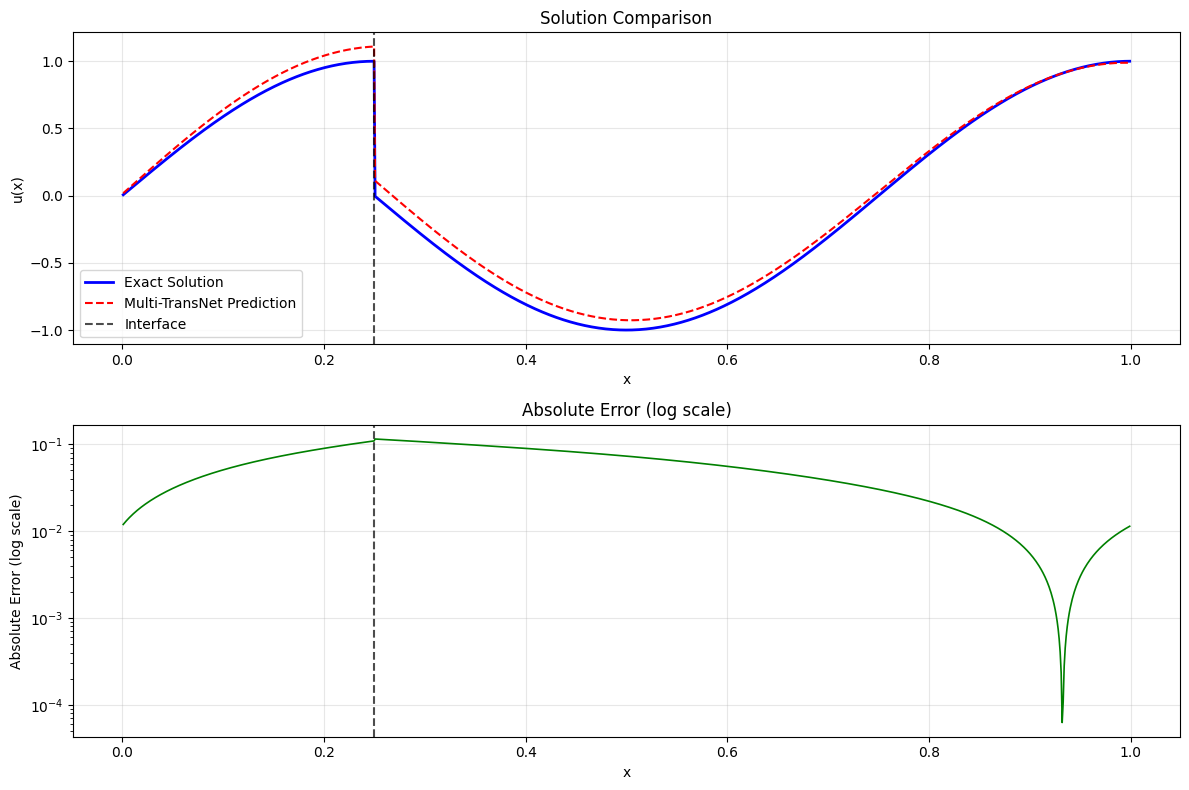

Relative L2 error: 9.089531e-02
Relative L_inf error: 1.152049e-01


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import golden

# -----------------------------
# Problem definition (1D test)
# -----------------------------
np.random.seed(42)

Omega = (0.0, 1.0)
Gamma = 0.25
Omega1 = (0.0, Gamma)
Omega2 = (Gamma, 1.0)

def beta(x):
    x = np.array(x)
    return np.where(x < Gamma, 1.0, 10.0)

def u_exact(x):
    x = np.array(x)
    return np.where(x <= Gamma, np.sin(2*np.pi*x), np.cos(2*np.pi*x))

def du_exact(x):
    x = np.array(x)
    return np.where(x <= Gamma, 2*np.pi*np.cos(2*np.pi*x), -2*np.pi*np.sin(2*np.pi*x))

# f(x) = -(beta u')' in subdomains where beta constant -> -beta * u''.
def f_rhs(x):
    x = np.array(x)
    left = -1.0 * (1.0) * (-(2*np.pi)**2 * np.sin(2*np.pi*x))   # = (2π)^2 sin
    right = -1.0 * (10.0) * (-(2*np.pi)**2 * np.cos(2*np.pi*x)) # = 10*(2π)^2 cos
    return np.where(x < Gamma, left, right)

# interface jumps h1 and h2
def h1_val():
    return u_exact(Gamma - 1e-12) - u_exact(Gamma + 1e-12)

def h2_val():
    # β_left * u'_left - β_right * u'_right
    du_left = 2*np.pi*np.cos(2*np.pi*Gamma)
    du_right = -2*np.pi*np.sin(2*np.pi*Gamma)
    return 1.0 * du_left - 10.0 * du_right

# boundary g
def g_val(x):
    return u_exact(x)

# 以上即根据真解计算出f, h1, h2, g

# -----------------------------
# Multi-TransNet parameters
# -----------------------------
# covering ball centers and radii for each subdomain
x_c1, R1 = 0.125, 0.135
x_c2, R2 = 0.625, 0.385

# neurons per subdomain
M1, M2 = 5, 5

# activation
def sigma(z):
    return np.tanh(z)

# hidden-layer randomized params
a1 = np.random.choice([-1.0, 1.0], size=M1)
a2 = np.random.choice([-1.0, 1.0], size=M2)
r1 = np.random.uniform(0.0, R1, size=M1)
r2 = np.random.uniform(0.0, R2, size=M2)

# -----------------------------
# Basis and operator builders
# -----------------------------
def build_basis(X, x_c, a, r, gamma, M):
    X = np.atleast_1d(X)
    N = len(X)
    basis = np.ones((N, M+1))
    for m in range(M):
        z = gamma * (a[m] * (X - x_c) + r[m])
        basis[:, m+1] = sigma(z)
    return basis

def build_L_basis(X, x_c, a, r, gamma, M, beta_func):
    """
    Build matrix for L(phi) = - (beta phi')' approximated by -beta * phi'' (inside subdomains).
    Use centered finite difference for phi'' with small h.
    """
    X = np.atleast_1d(X)
    N = len(X)
    basis = np.zeros((N, M+1))
    h = 1e-5
    for m in range(M):
        # evaluate phi at x-h, x, x+h vectorized
        z_c = gamma * (a[m] * (X - x_c) + r[m])
        z_p = gamma * (a[m] * (X + h - x_c) + r[m])
        z_m = gamma * (a[m] * (X - h - x_c) + r[m])
        phi_c = sigma(z_c)
        phi_p = sigma(z_p)
        phi_m = sigma(z_m)
        d2phi = (phi_p - 2.0*phi_c + phi_m) / (h*h)
        basis[:, m+1] = - beta_func(X) * d2phi
    # constant column stays zero (second derivative of const = 0)
    return basis

def build_J_basis(X, x_c, a, r, gamma, M, beta_func):
    """
    Build matrix for flux J(phi) = beta * phi' (normal in 1D).
    Use centered finite difference for phi' with small h.
    """
    X = np.atleast_1d(X)
    N = len(X)
    basis = np.zeros((N, M+1))
    h = 1e-5
    for m in range(M):
        z_p = gamma * (a[m] * (X + h - x_c) + r[m])
        z_m = gamma * (a[m] * (X - h - x_c) + r[m])
        phi_p = sigma(z_p)
        phi_m = sigma(z_m)
        dphi = (phi_p - phi_m) / (2.0*h)
        basis[:, m+1] = beta_func(X) * dphi
    return basis

# -----------------------------
# Sampling configuration (modified per your request)
# -----------------------------
# interior collocation points used in compute_loss (large sampling)
N_points = 10000
X1 = np.linspace(Omega1[0] + 1e-5, Omega1[1] - 1e-5, N_points//2)  # 5000
X2 = np.linspace(Omega2[0] + 1e-5, Omega2[1] - 1e-5, N_points//2)  # 5000

# boundary: 
n_bnd_each = 200
Xg_left = np.array([0.0] * n_bnd_each)
Xg_right = np.array([1.0] * n_bnd_each)

# interface: 
n_if_total = 400
n_if_each_side = n_if_total // 2
eps = 1e-4
# distribute points moving away from Gamma: small offsets
left_offsets = np.linspace(eps/n_if_each_side, eps, n_if_each_side)
right_offsets = np.linspace(eps/n_if_each_side, eps, n_if_each_side)
Xr_left = Gamma - left_offsets
Xr_right = Gamma + right_offsets
Xr = np.concatenate([Xr_left, Xr_right])  # length 100

# -----------------------------
# Loss / assembly for given gammas
# -----------------------------
def compute_loss(g1):
    # predict g2 from g1 using the relation used in your code pattern
    g2 = g1 * (R1 / R2) * (M2 / M1)

    # build basis and operator matrices
    Phi1 = build_basis(X1, x_c1, a1, r1, g1, M1)
    Phi2 = build_basis(X2, x_c2, a2, r2, g2, M2)
    L1 = build_L_basis(X1, x_c1, a1, r1, g1, M1, beta)
    L2 = build_L_basis(X2, x_c2, a2, r2, g2, M2, beta)

    # boundary basis (many repeated rows)
    Phi_g1 = build_basis(Xg_left, x_c1, a1, r1, g1, M1)   
    Phi_g2 = build_basis(Xg_right, x_c2, a2, r2, g2, M2)  

    # interface bases and flux
    Phi_r1 = build_basis(Xr, x_c1, a1, r1, g1, M1)   # (100, M1+1)
    Phi_r2 = build_basis(Xr, x_c2, a2, r2, g2, M2)   # (100, M2+1)
    J_r1 = build_J_basis(Xr, x_c1, a1, r1, g1, M1, beta)
    J_r2 = build_J_basis(Xr, x_c2, a2, r2, g2, M2, beta)

    # count rows
    n1 = len(X1)
    n2 = len(X2)
    nb = len(Phi_g1) + len(Phi_g2)   # 200
    ni = len(Xr)                     # 100 (each produces 2 equations => 200 rows)
    total_rows = n1 + n2 + nb + 2*ni
    total_cols = M1 + M2 + 2  # alpha1..alpha_M1, alpha0_1, alpha2..alpha_M2, alpha0_2

    F = np.zeros((total_rows, total_cols))
    T = np.zeros(total_rows)

    # PDE residuals Omega1
    F[0:n1, :M1+1] = L1
    T[0:n1] = f_rhs(X1)

    # PDE residuals Omega2
    F[n1:n1+n2, M1+1:] = L2
    T[n1:n1+n2] = f_rhs(X2)

    # boundary: left (x=0) -> fill rows
    idx_b_left_start = n1 + n2
    idx_b_left_end = idx_b_left_start + len(Phi_g1)
    F[idx_b_left_start:idx_b_left_end, :M1+1] = Phi_g1
    T[idx_b_left_start:idx_b_left_end] = g_val(0.0)

    # boundary: right (x=1)
    idx_b_right_start = idx_b_left_end
    idx_b_right_end = idx_b_right_start + len(Phi_g2)
    F[idx_b_right_start:idx_b_right_end, M1+1:] = Phi_g2
    T[idx_b_right_start:idx_b_right_end] = g_val(1.0)

    # interface rows start
    idx_if_start = idx_b_right_end

    # for each interface sampling point, add [u] equation: phi_left - phi_right = h1
    for i in range(ni):
        row = idx_if_start + i
        # left phi (M1+1), right phi (M2+1)
        F[row, :M1+1] = Phi_r1[i]
        F[row, M1+1:] = -Phi_r2[i]
        T[row] = h1_val()

    # for each interface sampling point, add flux jump equation: beta_left phi'_left - beta_right phi'_right = h2
    for i in range(ni):
        row = idx_if_start + ni + i
        F[row, :M1+1] = J_r1[i]
        F[row, M1+1:] = -J_r2[i]
        T[row] = h2_val()

    # solve least squares and return residual norm
    try:
        alpha, residuals, rank, s = np.linalg.lstsq(F, T, rcond=None)
        if len(residuals) > 0:
            return residuals[0]
        else:
            return np.linalg.norm(F @ alpha - T)
    except Exception as e:
        # fallback large penalty if solver fails
        return 1e12

# -----------------------------
# Golden-section search for gamma1
# -----------------------------
print("Starting golden-section search for gamma1 (this may take some time)...")
gamma1_opt = golden(lambda g: compute_loss(g), brack=(0.1, 10.0), tol=1e-3, full_output=False)
gamma2_opt = gamma1_opt * (R1 / R2) * (M2 / M1)
print(f"Found gamma1_opt = {gamma1_opt:.6e}, gamma2_opt = {gamma2_opt:.6e}")

# -----------------------------
# Final solve using gamma_opt with denser final collocation (kept moderate)
# -----------------------------
# final collocation inside each subdomain (smaller for speed but can be increased)
N_final = 1000
X1_final = np.linspace(Omega1[0] + 0.001, Omega1[1] - 0.001, N_final//2)
X2_final = np.linspace(Omega2[0] + 0.001, Omega2[1] - 0.001, N_final//2)

# final boundary: still 100 each
Phi_g1_final = build_basis(Xg_left, x_c1, a1, r1, gamma1_opt, M1)
Phi_g2_final = build_basis(Xg_right, x_c2, a2, r2, gamma2_opt, M2)

# final interface points (same Xr used)
Phi_r1_final = build_basis(Xr, x_c1, a1, r1, gamma1_opt, M1)
Phi_r2_final = build_basis(Xr, x_c2, a2, r2, gamma2_opt, M2)
J_r1_final = build_J_basis(Xr, x_c1, a1, r1, gamma1_opt, M1, beta)
J_r2_final = build_J_basis(Xr, x_c2, a2, r2, gamma2_opt, M2, beta)

L1_final = build_L_basis(X1_final, x_c1, a1, r1, gamma1_opt, M1, beta)
L2_final = build_L_basis(X2_final, x_c2, a2, r2, gamma2_opt, M2, beta)

# assemble final F and T
n1f = len(X1_final)
n2f = len(X2_final)
nbf = len(Phi_g1_final) + len(Phi_g2_final)  # 200
nif = len(Xr)  # 100
rows_final = n1f + n2f + nbf + 2*nif
cols_final = M1 + M2 + 2

Ff = np.zeros((rows_final, cols_final))
Tf = np.zeros(rows_final)

# PDE
Ff[0:n1f, :M1+1] = L1_final
Tf[0:n1f] = f_rhs(X1_final)
Ff[n1f:n1f+n2f, M1+1:] = L2_final
Tf[n1f:n1f+n2f] = f_rhs(X2_final)

# boundary
b_left_s, b_right_s = n1f + n2f, n1f + n2f + len(Phi_g1_final)
Ff[b_left_s:b_right_s, :M1+1] = Phi_g1_final
Tf[b_left_s:b_right_s] = g_val(0.0)
Ff[b_right_s:b_right_s+len(Phi_g2_final), M1+1:] = Phi_g2_final
Tf[b_right_s:b_right_s+len(Phi_g2_final)] = g_val(1.0)

# interface rows
start_if = b_right_s + len(Phi_g2_final)
for i in range(nif):
    Ff[start_if + i, :M1+1] = Phi_r1_final[i]
    Ff[start_if + i, M1+1:] = -Phi_r2_final[i]
    Tf[start_if + i] = h1_val()
for i in range(nif):
    Ff[start_if + nif + i, :M1+1] = J_r1_final[i]
    Ff[start_if + nif + i, M1+1:] = -J_r2_final[i]
    Tf[start_if + nif + i] = h2_val()

# solve final least squares
alpha_f, residuals_f, rank_f, s_f = np.linalg.lstsq(Ff, Tf, rcond=None)
print("Final LS residual (sum squares):", residuals_f if len(residuals_f)>0 else np.linalg.norm(Ff @ alpha_f - Tf)**2)

# split coefficients
alpha1 = alpha_f[:M1+1]
alpha2 = alpha_f[M1+1:]

# -----------------------------
# Evaluate the multi-transnet solution on a dense test grid
# -----------------------------
x_test = np.linspace(0.001, 0.999, 1000)
u_pred = np.zeros_like(x_test)
for i, xx in enumerate(x_test):
    if xx <= Gamma:
        B = build_basis([xx], x_c1, a1, r1, gamma1_opt, M1)  # shape (1, M1+1)
        u_pred[i] = B.dot(alpha1)
    else:
        B = build_basis([xx], x_c2, a2, r2, gamma2_opt, M2)
        u_pred[i] = B.dot(alpha2)

u_true = u_exact(x_test)

# -----------------------------
# Plot results
# -----------------------------
plt.figure(figsize=(12, 8))

plt.subplot(2,1,1)
plt.plot(x_test, u_true, 'b-', linewidth=2, label='Exact Solution')
plt.plot(x_test, u_pred, 'r--', linewidth=1.5, label='Multi-TransNet Prediction')
plt.axvline(Gamma, color='k', linestyle='--', alpha=0.7, label='Interface')
plt.xlabel('x'); plt.ylabel('u(x)')
plt.title('Solution Comparison')
plt.legend(); plt.grid(alpha=0.3)

plt.subplot(2,1,2)
err = np.abs(u_pred - u_true)
plt.semilogy(x_test, err, 'g-', linewidth=1.2)
plt.axvline(Gamma, color='k', linestyle='--', alpha=0.7)
plt.xlabel('x'); plt.ylabel('Absolute Error (log scale)')
plt.title('Absolute Error (log scale)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# -----------------------------
# Compute relative errors
# -----------------------------
rel_l2 = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true)
rel_inf = np.max(np.abs(u_pred - u_true)) / np.max(np.abs(u_true))
print(f"Relative L2 error: {rel_l2:.6e}")
print(f"Relative L_inf error: {rel_inf:.6e}")
